In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

In [3]:
#CampC_data = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/IceCores/CampCentury.txt', '\s+', comment='#', names=['yr', 'depth', 'cm', 'antal', 'lambda', 'd18O', 'krads', 'proeve', 'optalt', 'test'])
#dye2_data = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/IceCores/dye2.txt', '\s+', comment='#', names=['yr', 'depth', 'cm', 'antal', 'lambda', 'd18O', 'krads', 'proeve', 'optalt', 'test'])
#dye3_data = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/IceCores/dye3.txt', '\s+', comment='#', names=['depth','d18O'])
#CampC_data.drop(CampC_data.tail(1).index,inplace=True)
#dye2_data.drop(dye2_data.tail(1).index,inplace=True)

In [4]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [5]:
site = 'Crete'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

No ECM file found, setting empty df instead


In [6]:
maxDiff = max(np.diff(depth_LT))
minDiff = min(np.diff(depth_LT))
Delta0 = (maxDiff + minDiff)/2

In [7]:
interval = np.array([min(depth_LT), max(depth_LT)])

interpTypeAll = 'CubicSpline'

inst = Interpolation(depth_LT, pd.Series(d18O_LT), interval, interpTypeAll, DeltaInput=True, samplingSize=Delta0)
depth_LT_int, d18O_LT_int, Delta = inst()

In [8]:
dataAll = pd.DataFrame({'depth':depth_LT_int,'d18O':d18O_LT_int}, index=None)

In [9]:
inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True, newDelta=0.01)


Starting sigma: 6.28 [cm]
Final sigma: 5.99 [cm]
Final # of peaks: 32
Delta: 0.026
Delta new: 0.010


In [12]:
def linear_Timescale(x_in,y_in,idxPeaks, D_in):
    xPeak0 = x_in[idxPeaks[0]]
    
    x0 = x_in - xPeak0
    D = D_in
    
    N_btwPeaks = np.diff(idxPeaks)
    
    d = D/N_btwPeaks
    
    N_peaks = len(idxPeaks)
    
    dPeaks = np.arange(0,N_peaks,D)
    
    xNewArr = []
    for i in range(len(dPeaks)-1):
        xNewArr.append(np.arange(dPeaks[i],dPeaks[i+1], d[i]))

    xNewArr.append(np.array([N_peaks-1]))
    
    xNew = np.concatenate(np.asarray(xNewArr))
    yNew = y_in[idxPeaks[0]:idxPeaks[-1]+1]
    
    
    return xNew, yNew

In [13]:
xNew, yNew = linear_Timescale(depth1, data, peaks, 1)

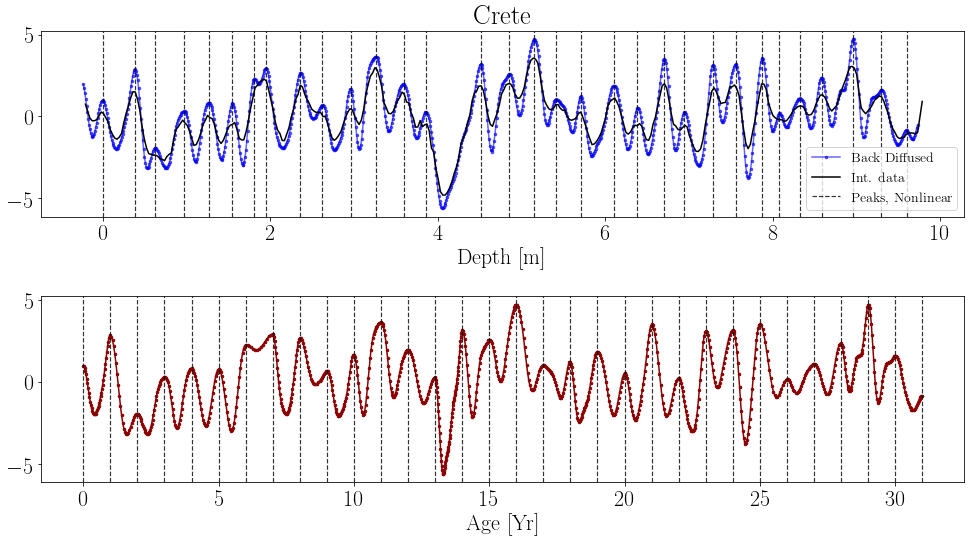

In [22]:
fig, axes = plt.subplots(2,1,figsize=(14,8))

axes.flatten()[0].plot(depth1-depth1[peaks[0]],data, '-', marker='.',label='Back Diffused', ms=5, color='blue', alpha=0.6)
axes.flatten()[0].plot(depth_LT_int-depth1[peaks[0]],d18O_LT_int-np.mean(d18O_LT_int),'-', color='k', label='Int. data')
for i in range(len(peaks)):
    axes.flatten()[0].axvline(x=depth1[peaks[i]]-depth1[peaks[0]], ls='--', color='k', label='Peaks, Nonlinear', lw=1.2, alpha=0.8)
axes.flatten()[0].set(xlabel='Depth [m]', title=site)
axes.flatten()[0].legend(fontsize=14)


axes.flatten()[1].plot(xNew,yNew, label='Back diffused', ls='-', marker='.', ms=5, color='darkred')
for i in range(len(peaks)):
    axes.flatten()[1].axvline(xNew[int(peaks[i]-peaks[0])], ls='--', alpha=0.8,color='k', lw=1.2, label='Peaks, linear')
axes.flatten()[1].set(xlabel='Age [Yr]')
fig.tight_layout()